## Gaussian Processes (GP) with GPyTorch

In this notebook we are going to use [GPyTorch](https://gpytorch.ai/) library for GP modeling.

Why **GPyTorch**?

* State of the art GP models
* Built on top of pytorch having all its advantages (GPU, autograd, etc)


Run the following line to install GPyTorch library

In [1]:
# !pip install gpytorch

In [2]:
%matplotlib inline


import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch import kernels


import utils
import tqdm

Current documentation of GPyTorch library can be found [here](https://gpytorch.readthedocs.io/en/latest/).

## Gaussian Process Regression

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise .

Posterior distribution
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$

## Building GPR model

Lets fit GPR model for function $f(x) = − \cos(\pi x) + \sin(4\pi x)$ in $[0, 1]$,
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

In [3]:
torch.manual_seed(1150061746)

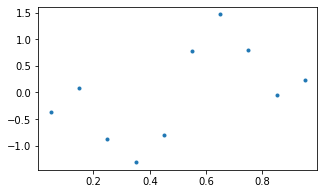

In [4]:
N = 10
X = torch.linspace(0.05, 0.95, N)
y = -torch.cos(np.pi * X) + np.sin(4 * np.pi * X) + torch.randn(N) * 0.1
plt.figure(figsize=(5, 3))
plt.plot(X.numpy(), y.numpy(), '.')

#### 1. Define covariance function

The most popular kernel - RBF kernel (`kernels.RBFKernel`) - is defined as follows in gpytorch, $k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  
Usually, there is also a coefficient $A$ that scales the kernel.  
In gpytorch we can add the scaling coefficient using `kernels.ScaleKernel` as follows
```python
kernel = kernels.RBFKernel()
kernel = kernels.ScaleKernel(kernel)
```

In [5]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())

In [6]:
# We will use the simplest form of GP model, exact inference
class GPRegressor(gpytorch.models.ExactGP):
    def __init__(self, X, y, kernel, likelihood=None):
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        super().__init__(X, y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.kernel = kernel
        self.likelihood = likelihood
    
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return self.likelihood(pred)

#### 2. Create GPR model

In [7]:
model = GPRegressor(X, y, kernel)

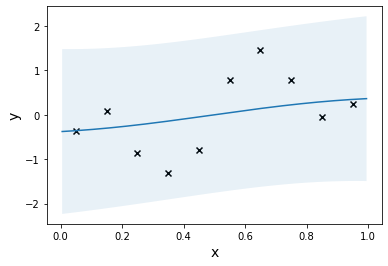

In [8]:
utils.plot_model(model)

### Parameters of the covariance function

Values of parameters of covariance function can be set like:  `kernel.lengthscale = 0.1`.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

In [9]:
def plot_kernel(kernel, xlim=None, ax=None):
    if xlim is None:
        xlim = [-3, 5]
    x = torch.linspace(xlim[0], xlim[1], 100)
    with torch.no_grad():
        K = kernel(x, torch.ones((1))).evaluate().reshape(-1, 1)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(x.numpy(), K.cpu().numpy())

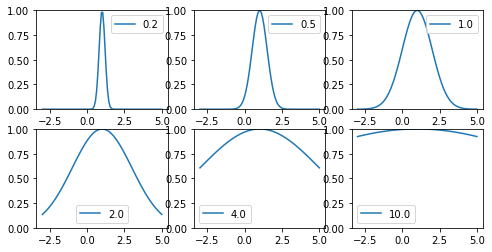

In [10]:
k = kernels.RBFKernel()
theta = np.asarray([0.2, 0.5, 1, 2, 4, 10])
figure, axes = plt.subplots(2, 3, figsize=(8, 4))
for t, ax in zip(theta, axes.ravel()):
    k.lengthscale = t
    plot_kernel(k, ax=ax)
    ax.set_ylim([0, 1])
    ax.legend([t])

### Task
Try to change parameters to obtain more accurate model.

**Question**: based on the input points `X` can we guess the `lengthscale` approximately?

In [11]:
######## Your code goes here ########
kernel = kernels.ScaleKernel(kernels.RBFKernel())
kernel.base_kernel.lengthscale = 0.1

model = GPRegressor(X, y, kernel)
### Your code ends here ###

Check yourself

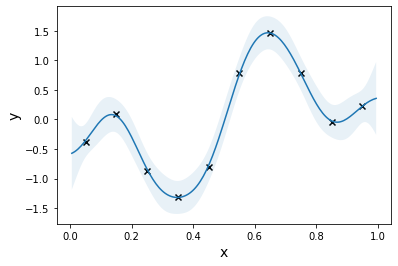

In [12]:
model.likelihood.noise = 0.01
utils.plot_model(model)

### Tuning parameters of the covariance function

The parameters are tuned by maximizing likelihood. To do it just use `optimize()` method of the model.

In [13]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)

In [14]:
# Find optimal model hyperparameters
def train(model, X, y, n_epochs=100, fix_noise_variance=None, verbose=True):
    """
    """
    model.train()

    # Use the adam optimizer
    if fix_noise_variance is not None:
        model.likelihood.noise = fix_noise_variance
        training_parameters = [p for name, p in model.named_parameters()
                               if not name.startswith('likelihood')]
    else:
        training_parameters = model.parameters()
        
    optimizer = torch.optim.Adamax(training_parameters, lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    with tqdm.trange(n_epochs, disable=not verbose) as bar:
        for i in bar:
    
            optimizer.zero_grad()
            
            out = model(X)
            loss = -mll(out, y)
            loss.backward()

            optimizer.step()
                        
            # display progress bar
            postfix = dict(Loss=f"{loss.item():.3f}",
                           noise=f"{model.likelihood.noise.item():.3}")
            
            if (hasattr(model.kernel, 'base_kernel') and
                hasattr(model.kernel.base_kernel, 'lengthscale')):
                lengthscale = model.kernel.base_kernel.lengthscale
                if lengthscale is not None:
                    lengthscale = lengthscale.squeeze(0).detach().cpu().numpy()
            else:
                lengthscale = model.kernel.lengthscale

            if lengthscale is not None:
                if len(lengthscale) > 1:
                    lengthscale_repr = [f"{l:.3f}" for l in lengthscale]
                    postfix['lengthscale'] = f"{lengthscale_repr}"
                else:
                    postfix['lengthscale'] = f"{lengthscale[0]:.3f}"
                
            bar.set_postfix(postfix)

100%|██████████| 100/100 [00:01<00:00, 83.96it/s, Loss=0.848, noise=0.0171, lengthscale=0.131]


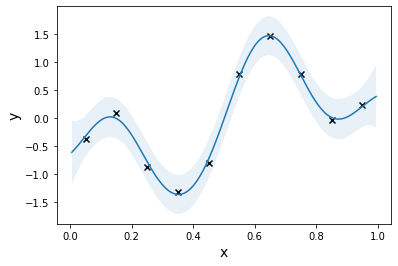

In [15]:
train(model, X, y)
utils.plot_model(model)

### Noise variance

Noise variance acts like a regularization in GP models. Larger values of noise variance lead to more smooth model.  

**Task**: try to change noise variance to some large value, to some small value and plot the results.

Noise variance accessed like this: `model.Gaussian_noise.variance = 1`

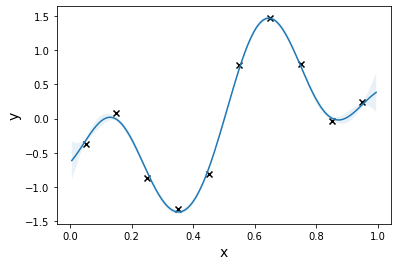

In [16]:
######## Your code here ########
model.likelihood.noise = 0.0001
utils.plot_model(model)

Now, let's generate more noisy data and try to fit model.

100%|██████████| 100/100 [00:00<00:00, 117.16it/s, Loss=1.005, noise=0.291, lengthscale=0.133]


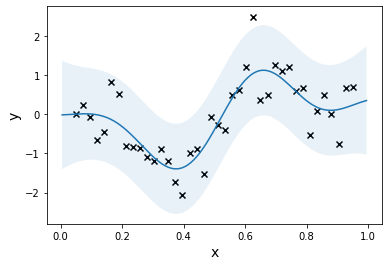

In [17]:
N = 40
X = torch.linspace(0.05, 0.95, N)
y = -torch.cos(np.pi * X) + torch.sin(4 * np.pi * X) + torch.randn(N) * 0.5

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)

train(model, X, y)
utils.plot_model(model)

Now, let's fix noise variance to some small value and fit the model

100%|██████████| 200/200 [00:00<00:00, 215.48it/s, Loss=1.346, noise=0.1, lengthscale=0.145]


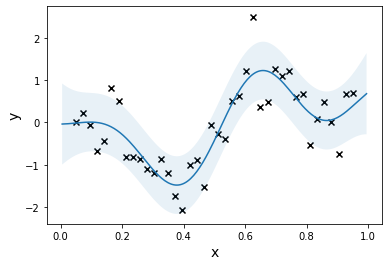

In [18]:
kernel = kernels.ScaleKernel(kernels.RBFKernel())

model = GPRegressor(X, y, kernel)

train(model, X, y, fix_noise_variance=0.1, n_epochs=200)

utils.plot_model(model)

## Approximate multi-dimensional function

In [19]:
def rosenbrock(x):
    x = 0.5 * (4 * x - 2)
    y = np.sum((1 - x[:, :-1])**2 +
                   100 * (x[:, 1:] - x[:, :-1]**2)**2, axis=1)
    return y

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error


def plot_2d_func(func, n_rows=1, n_cols=1, title=None):
    grid_size = 100
    x_grid = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
    x_grid = np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))
    y = func(x_grid)
    fig = plt.figure(figsize=(n_cols * 6, n_rows * 6))
    ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
    ax.plot_surface(x_grid[:, 0].reshape(grid_size, grid_size), x_grid[:, 1].reshape(grid_size, grid_size),
                    y.reshape(grid_size, grid_size),
                    cmap=cm.jet, rstride=1, cstride=1)
    if title is not None:
        ax.set_title(title)
    return fig

#### Here how the function looks like in 2D

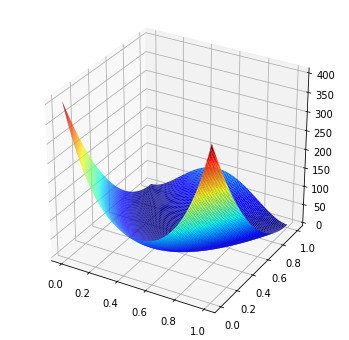

In [21]:
fig = plot_2d_func(rosenbrock)

### Training set
Note that it is 3-dimensional now

In [22]:
dim = 3
X = torch.tensor(np.random.rand(300, dim), dtype=torch.float64)
y = torch.from_numpy(rosenbrock(X.numpy()))

### Task

Try to approximate Rosenbrock function using RBF kernel. MSE (mean squared error) should be $<10^{-2}$.
**Hint**: if results are not good maybe it is due to bad local minimum. You can do one of the following things:
0. Use `double()` for all evaluations
1. Try to use different initial values of hyperparameters.
2. Constrain model parameters to some reasonable bounds. You can do it for example as follows: 

```
constraint = gpytorch.constraints.Interval(0.0, 1.0)
kernel = kernels.RBFKernel(lengthscale_constraint=constraint)
```
3. What about scaling of the data? Does it affect kernel matrix?

In [23]:
######## Your code here ########

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y_train = torch.tensor(scaler.fit_transform(y.numpy().reshape(-1, 1))).squeeze()


kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y_train, kernel)

constraint = gpytorch.constraints.Interval(0.0, 1.0)
model.likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=constraint)
model.double()

train(model, X, y_train, n_epochs=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]/home/yeahrmek/miniconda3/envs/bayes_opt/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1500/1500 [01:01<00:00, 24.57it/s, Loss=-2.856, noise=2.42e-08, lengthscale=0.904]


In [24]:
print(f"Outputscale: {model.kernel.outputscale.item():.3f}\n"
      f"Lengthscale: {model.kernel.base_kernel.lengthscale.detach().cpu().numpy()[0]}\n"
      f"Noise variance: {model.likelihood.noise.item()}")

Outputscale: 11.413
Lengthscale: [0.9036977]
Noise variance: 2.422758221831431e-08


**Task**: calculate MSE

In [25]:
x_test = np.random.rand(3000, dim)
y_test = rosenbrock(x_test)
model.eval()

# Turn off some optimization if gpytorch for more accurate computation of the prediction
with gpytorch.settings.fast_computations(False, False, False):
    y_pr = model.predict(torch.from_numpy(x_test)).mean.numpy()

    
### Your code goes here ### 
# Calculate Mean Squared Error using y_pr as a prediction

mse = mean_squared_error(y_test.ravel(),
                         scaler.inverse_transform(y_pr.ravel()))

### Your code ends here ###


print('\nMSE: {}'.format(mse))


MSE: 0.022563672189836893


# Covariance functions

The most popular covariance function is RBF. However, not all the functions can be modelled using RBF covariance function. For example, approximations of discontinuous functions will suffer from oscillations, approximation of curvy function may suffer from oversmoothing.

In [26]:
def heaviside(x):
    return np.asfarray(x > 0)


def rastrigin(x):
    """
    Parameters
    ----------
    x : ndarray - 2D array in [0, 1]
    
    Returns
    -------
    y : 1D array of values of Rastrigin function
    """
    scale = 8  # 10.24
    x = scale * x - scale / 2
    y = 10 * x.shape[1] + (x**2).sum(axis=1) - 10 * np.cos(2 * np.pi * x).sum(axis=1)
    return y

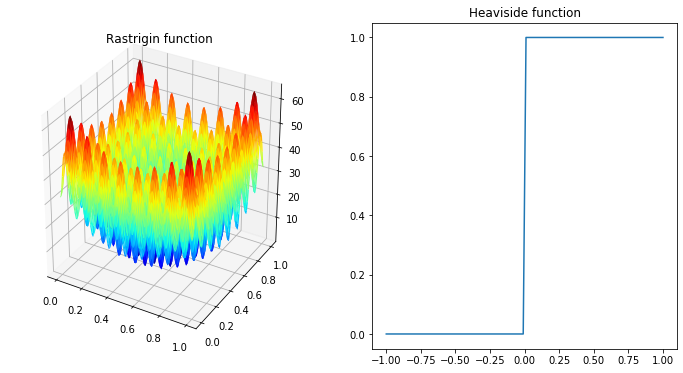

In [27]:
fig = plot_2d_func(rastrigin, 1, 2, title='Rastrigin function')

x = np.linspace(-1, 1, 100)
y = heaviside(x)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y)
ax.set_title('Heaviside function')
plt.show()

#### Example of oscillations
As you can see there are oscillations in viscinity of discontinuity because we are trying to approximate
discontinuous function using infinitily smooth function.

100%|██████████| 100/100 [00:00<00:00, 145.35it/s, Loss=-0.850, noise=0.00109, lengthscale=0.082]


(-0.2, 1.2)

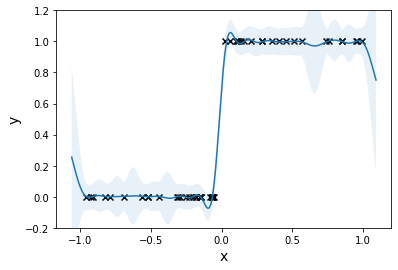

In [28]:
# torch.manual_seed(1150061746)
X = torch.rand(50, 1) * 2 - 1
y = torch.tensor(heaviside(X.numpy())).float().squeeze()

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)
train(model, X, y)

utils.plot_model(model)
plt.ylim([-0.2, 1.2])

#### Example of oversmoothing
Actually, the GP model only approximates trend of the function.
All the curves are treated as noise.
The knowledge about this (in fact there is some repeated structure) should be incorporated into the model via kernel function.

100%|██████████| 100/100 [00:03<00:00, 22.34it/s, Loss=20.444, noise=2.93, lengthscale=0.354]


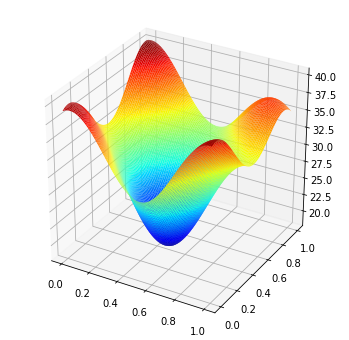

In [29]:
np.random.seed(42)

X = torch.rand(300, 2)
y = torch.tensor(rastrigin(X.numpy()), dtype=torch.float32).squeeze()

kernel = kernels.ScaleKernel(kernels.RBFKernel())
model = GPRegressor(X, y, kernel)
train(model, X, y)

fig = plot_2d_func(lambda x: model.predict(torch.tensor(x).float()).mean.numpy())

### Covariance functions

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `Periodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Polynomial
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* Periodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

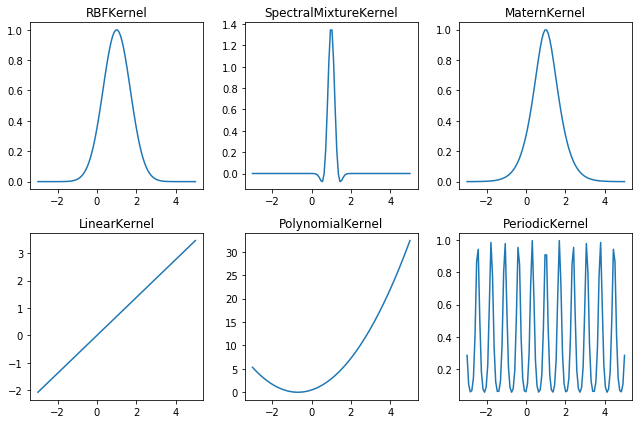

In [30]:
covariance_functions = [kernels.RBFKernel(), kernels.SpectralMixtureKernel(2),
                        kernels.MaternKernel(nu=5/2), kernels.LinearKernel(power=1),
                        kernels.PolynomialKernel(power=2), kernels.PeriodicKernel(),
                       ]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for i, k in enumerate(covariance_functions):
    plot_kernel(k, ax=axes[i])
    axes[i].set_title(str(k).split('(')[0])
figure.tight_layout()

## Combination of covariance functions

* Sum of covariance function is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPytorch

In GPytorch to combine covariance functions you can just use operators `+` and `*`.

Let's plot some of the combinations

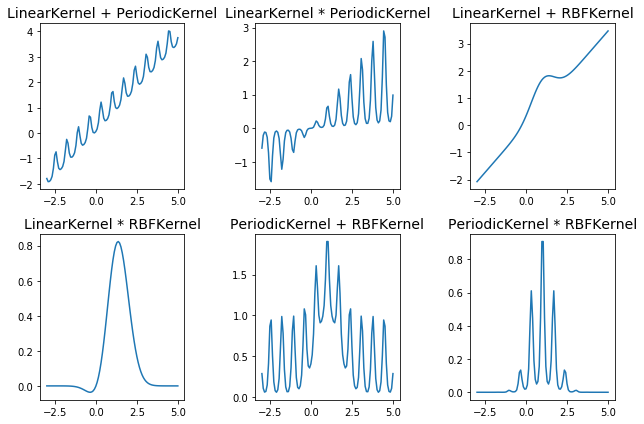

In [31]:
covariance_functions = [kernels.LinearKernel(power=1), kernels.PeriodicKernel(),
                        kernels.RBFKernel()]
operations = {'+': lambda x, y: x + y,
              '*': lambda x, y: x * y}

figure, axes = plt.subplots(len(operations), len(covariance_functions), figsize=(9, 6))

import itertools
axes = axes.ravel()
count = 0
for j, base_kernels in enumerate(itertools.combinations(covariance_functions, 2)):
    for k, (op_name, op) in enumerate(operations.items()):
        kernel = op(base_kernels[0], base_kernels[1])
        plot_kernel(kernel, ax=axes[count])
        kernel_names = [
            str(base_kernels[i]).split('(')[0] for i in [0, 1]
        ]
        axes[count].set_title('{} {} {}'.format(kernel_names[0], op_name, kernel_names[1]),
                              fontsize=14)
        count += 1
figure.tight_layout()

### Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, y) = k_1(x_1, y_1) + k_2(x_2, y_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, y) = k_1(x, y) + \ldots + k_D(x, y),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.

Here is an example of ${\rm RBF}(x_1) + {\rm RBF}(x_2)$

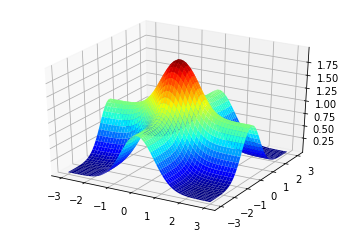

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create kernel
k1 = kernels.RBFKernel(active_dims=[0])
k2 = kernels.RBFKernel(active_dims=[1])

kernel = k1 + k2

# evaluate kernel on grid
x = torch.meshgrid(torch.linspace(-3, 3, 50), torch.linspace(-3, 3, 50))
x = torch.cat([x[0].reshape(-1, 1), x[1].reshape(-1, 1)], dim=1)

with torch.no_grad():
    z = kernel(x, torch.tensor([[0., 0.]])).evaluate()

# Plot kernel
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50).numpy(),
                x[:, 1].reshape(50, 50).numpy(),
                z.reshape(50, 50).numpy(), cmap=cm.jet)
plt.show()

### Kernels on arbitrary types of objects

Kernels can be defined over all types of data structures: text, images, matrices, graphs, etc. You just need to define similarity between objects.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

## 2 Sampling from GP

So, you have defined some complex kernel.
You can plot it to see how it looks and guess what kind of functions it can approximate.
Another way to do it is to actually generate random functions using this kernel.

GP defines distribution over functions, which is defined by its *mean function* $m(x)$ and *covariance function* $k(x, y)$: for any set $\mathbf{x}_1, \ldots, \mathbf{x}_N \in \mathbb{R}^d \rightarrow$ $\left (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_N) \right ) \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$,
where $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.

Sampling procedure:

1. Generate set of points $\mathbf{x}_1, \ldots, \mathbf{x}_N$.
2. Calculate mean and covariance matrix $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.
3. Generate vector from multivariate normal distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$.

Below try to change RBF kernel to some other kernel and see the results.

/home/yeahrmek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


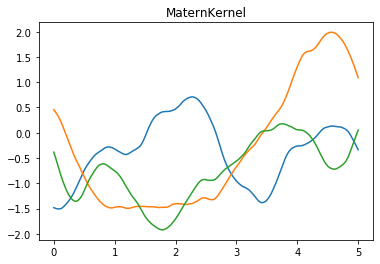

In [33]:
kernel = kernels.MaternKernel(nu=5/2)

X = torch.linspace(0, 5, 500)

mu = np.zeros(500)

with torch.no_grad():
    C = kernel(X).evaluate().numpy()

Z = np.random.multivariate_normal(mu, C, 3)

plt.figure()
for i in range(3):
    plt.plot(X.numpy(), Z[i, :])
    plt.title(str(kernel).split('(')[0])

### Task

Build a GP model that predicts airline passenger counts on international flights.

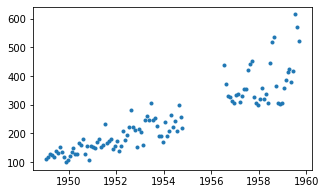

In [34]:
data = np.load('airline.npz')

X = torch.tensor(data['X'])
y = torch.tensor(data['y']).squeeze()

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

plt.figure(figsize=(5, 3))
plt.plot(X_train.numpy(), y_train.numpy(), '.')

You need to obtain something like this

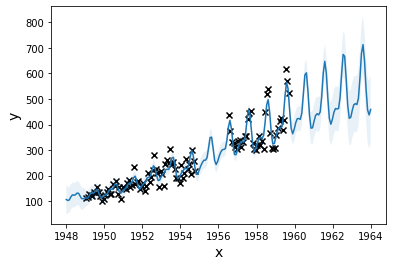

#### Let's try RBF kernel

In [35]:
######## Your code here ########
k_rbf = kernels.ScaleKernel(kernels.RBFKernel())

As you can see below it doesn't work ;(

100%|██████████| 500/500 [00:04<00:00, 110.47it/s, Loss=422.300, noise=5.75, lengthscale=3.556]


likelihood.noise_covar.raw_noise: 5.751
mean.constant: 6.868
kernel.raw_outputscale: 4.100
kernel.base_kernel.raw_lengthscale: 3.527


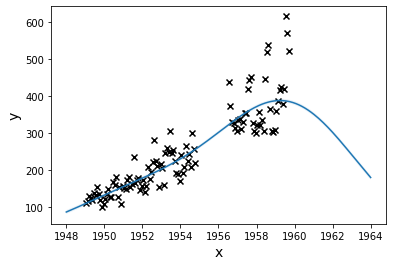

In [36]:
model = GPRegressor(X_train, y_train, k_rbf).double()
train(model, X_train, y_train, n_epochs=500)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
xlim = [1948, 1964]
utils.plot_model(model, xlim=xlim)

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

#### Let's first try to model trend

Trend is almost linear with some small nonlinearity, so you can use sum of linear kernel with some other which gives this small nonlinearity.

In [37]:
######## Your code here ########
k_trend = kernels.ScaleKernel(kernels.PolynomialKernel(power=1)) + kernels.ScaleKernel(kernels.RBFKernel())

100%|██████████| 1000/1000 [00:08<00:00, 118.10it/s, Loss=183.463, noise=8.16]


likelihood.noise_covar.raw_noise: 8.157
mean.constant: -18.798
kernel.kernels.0.raw_outputscale: -3.795
kernel.kernels.0.base_kernel.raw_offset: 2.360
kernel.kernels.1.raw_outputscale: 6.854
kernel.kernels.1.base_kernel.raw_lengthscale: 1.104


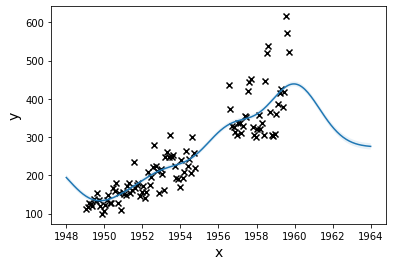

In [38]:
model = GPRegressor(X_train, y_train, k_trend).double()
train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
utils.plot_model(model, xlim=xlim)

#### Let's model periodicity
Just periodic kernel will not work (why?).
Try to use product of periodic kernel with some other kernel (or maybe 2 other kernels).
Note that the amplitude increases with x.

In [39]:
######## Your code here ########
k_trend = (kernels.ScaleKernel(kernels.PolynomialKernel(power=1)) +
           kernels.ScaleKernel(kernels.RBFKernel()))

k_seasonal = (kernels.ScaleKernel(kernels.PeriodicKernel()) *
              kernels.LinearKernel() * 
              kernels.ScaleKernel(kernels.RBFKernel()))

100%|██████████| 1000/1000 [00:13<00:00, 74.22it/s, Loss=5.510, noise=8.66]


likelihood.noise_covar.raw_noise: 8.656
mean.constant: 95.919
kernel.kernels.0.kernels.0.raw_outputscale: -4.959
kernel.kernels.0.kernels.0.base_kernel.raw_offset: -1.022
kernel.kernels.0.kernels.1.raw_outputscale: 91.791
kernel.kernels.0.kernels.1.base_kernel.raw_lengthscale: 2.898
kernel.kernels.1.kernels.0.kernels.0.raw_outputscale: -1.992
kernel.kernels.1.kernels.0.kernels.0.base_kernel.raw_lengthscale: -0.224
kernel.kernels.1.kernels.0.kernels.0.base_kernel.raw_period_length: 0.125
kernel.kernels.1.kernels.0.kernels.1.raw_variance: -1.992
kernel.kernels.1.kernels.1.raw_outputscale: -1.992
kernel.kernels.1.kernels.1.base_kernel.raw_lengthscale: -0.447


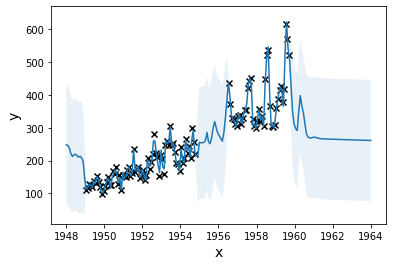

In [40]:
kernel = kernels.AdditiveKernel(k_trend, k_seasonal)

model = GPRegressor(X_train, y_train, kernel).double()

train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")
    
utils.plot_model(model, xlim=xlim)

#### Let's add noise model
The dataset is heteroscedastic, i.e. noise variance depends on x: it increases linearly with x.  
To model homoscedastic white noise we implement `WhiteNoiseKernel`, but it assumes that noise variance is the same at every x.
By what kernel it should be multiplied?

In [41]:
from gpytorch.lazy import DiagLazyTensor, ZeroLazyTensor

class WhiteNoiseKernel(kernels.Kernel):
    def __init__(self, noise=1):
        super().__init__()
        self.noise = noise
    
    def forward(self, x1, x2, **params):
        if self.training and torch.equal(x1, x2):
            return DiagLazyTensor(torch.ones(x1.shape[0]).to(x1) * self.noise)
        elif x1.size(-2) == x2.size(-2) and torch.equal(x1, x2):
            return DiagLazyTensor(torch.ones(x1.shape[0]).to(x1) * self.noise)
        else:
            return torch.zeros(x1.shape[0], x2.shape[0]).to(x1)

In [42]:
######## Your code here ########
k_trend = (kernels.ScaleKernel(kernels.PolynomialKernel(power=1)) +
           kernels.ScaleKernel(kernels.RBFKernel()))

k_seasonal = kernels.ScaleKernel(
    kernels.PeriodicKernel() * kernels.LinearKernel() * kernels.RBFKernel()
)


k_noise = kernels.ScaleKernel(WhiteNoiseKernel(noise=0.1)) * kernels.LinearKernel()

100%|██████████| 1000/1000 [00:15<00:00, 65.72it/s, Loss=5.096, noise=0.108]


likelihood.noise_covar.raw_noise: -2.175
mean.constant: 97.008
kernel.kernels.0.kernels.0.raw_outputscale: -5.005
kernel.kernels.0.kernels.0.base_kernel.raw_offset: -0.419
kernel.kernels.0.kernels.1.raw_outputscale: 74.350
kernel.kernels.0.kernels.1.base_kernel.raw_lengthscale: 8.444
kernel.kernels.1.raw_outputscale: -2.452
kernel.kernels.1.base_kernel.kernels.0.kernels.0.raw_lengthscale: 2.370
kernel.kernels.1.base_kernel.kernels.0.kernels.0.raw_period_length: 0.543
kernel.kernels.1.base_kernel.kernels.0.kernels.1.raw_variance: -2.452
kernel.kernels.1.base_kernel.kernels.1.raw_lengthscale: 6.424
kernel.kernels.2.kernels.0.raw_outputscale: -3.005
kernel.kernels.2.kernels.1.raw_variance: -3.005


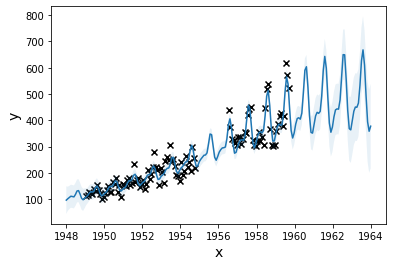

In [43]:
kernel = kernels.AdditiveKernel(k_trend, k_seasonal, k_noise)

model = GPRegressor(X_train, y_train, kernel).double()

train(model, X_train, y_train, n_epochs=1000)

for name, p in model.named_hyperparameters():
    print(f"{name}: {p.item():.3f}")

utils.plot_model(model, xlim=xlim)

<br>
<br>

# *Bonus tasks

## Automatic covariance structure search
We can construct kernel is automatic way.
Here is our data set (almost the same)

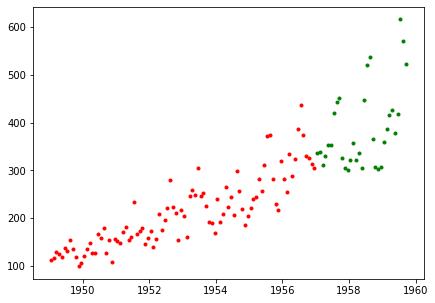

In [44]:
idx_test = np.where((X.numpy()[:,0] > 1957))[0]
idx_train = np.where((X.numpy()[:,0] <= 1957))[0]
X_train = X[idx_train]
y_train = y[idx_train]

X_test = X[idx_test]
y_test = y[idx_test]

plt.figure(figsize=(7, 5))
plt.plot(X_train.numpy(), y_train.numpy(), '.', color='red');
plt.plot(X_test.numpy(), y_test.numpy(), '.', color='green');

In [45]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.numpy().reshape(-1, 1))
y_train = torch.tensor(y_train).squeeze()
y_test = torch.tensor(scaler_y.transform(y_test.numpy().reshape(-1, 1))).squeeze()

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train.numpy().reshape(-1, 1))
X_train = torch.tensor(X_train)
X_test = torch.tensor(scaler_x.transform(X_test))

In [46]:
def plot_model_learned(model, X_test, y_test):
    utils.plot_model(model, xlim=[-2, 3])
    plt.plot(X_test.numpy(), y_test.numpy(), '.', color='green')

## Expressing Sturcture Through Kernels

For example:

$$
\underbrace{\text{RBF}\times\text{Lin}}_\text{increasing trend} + \underbrace{\text{RBF}\times\text{Per}}_\text{varying-amplitude periodic} + \underbrace{\text{RBF}}_\text{residual}
$$

## Greedy Searching for the Optimum Kernel Combination

One can wonder: how to automatically search the kernel structure? We can optimize some criteria, which balance between a loss function value and the complexity of the model.
Reasinobale candidate for this is BIC-criteria:

$$
BIC = - 2. \text{Log-Liklihood} + m \cdot\log{n}
$$

where $n$ sample size and $m$ number of the parameters.

However, the procedure of fitting Gaussian Process is quite expensive $O(n^3)$. Hence,  instead of the combinatorial search through all possible combinations, we grow the kernel structure greedy.

You can find more details at the https://github.com/jamesrobertlloyd/gp-structure-search. For now, we present toy-example algorithm.

Consider the set of operations:

$$
\text{Algebra: } +,\times
$$

and the set of basic kernels:

$$
\text{Kernels: } \text{Poly}, \text{RBF}, \text{Periodic}
$$

For each level we select extenstion of our current kernel with the lowest BIC. This is an example of the possible kernel grow process (mark notes the lowest BIC at the level):

<img src='gp.png'>

### Task*
Implement function that trains a model with given kernel and dataset, calculates and returns BIC
The marginal log-lilkelihood of the model can be calculated using `gpytorch.mlls.ExactMarginalLogLikelihood`,
number of parameters of the model you can get by counting number of `model.hyperparameters()`.

In [47]:
import copy


def train_model_get_bic(X_train, y_train, kernel, n_epochs=300):
    """
    Train GP model and calculate Bayesian Information Criterion (BIC)
    
    Parameters
    ----------
    X_train : torch.tensor
        Array of train features, n*d (d>=1)
    
    y_train : torch.tensor
        Array of target values
        
    kernel : gpytorch.kernels.Kernel
        Kernel object
        
    n_epochs : int
        Number of epochs to train GP model
        
    Returns
    -------
    bic : float
        BIC value
    """
    kernel = copy.deepcopy(kernel)
    
    ######## Your code here ########
    
    model = GPRegressor(X_train, y_train, kernel).double()
    train(model, X_train, y_train, n_epochs=n_epochs, verbose=False)
    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    with torch.no_grad():
        log_ll = mll(model(X_train), y_train) * X_train.shape[0]
        
    N = X_train.shape[0]
    m = sum(p.numel() for p in model.hyperparameters())
    bic = -2 * log_ll + m * np.log(N)

    return bic 

Here is a utility function which take list of kernels and operations between them, calculates all product kernels
and returns a list of them.
After that we need only take sum of the kernels from this list.

In [48]:
def _get_all_product_kernels(op_list, kernel_list):
    """
    Find product pairs and calculate them.
    For example, if we are given expression:
        K = k1 * k2 + k3 * k4 * k5
    the function will calculate all the product kernels
        k_mul_1 = k1 * k2
        k_mul_2 = k3 * k4 * k5
    and return list [k_mul_1, k_mul_2].
    """
    product_index = np.where(np.array(op_list) == '*')[0]
    if len(product_index) == 0:
        return kernel_list

    product_index = product_index[0]
    product_kernel = kernel_list[product_index] * kernel_list[product_index + 1]
    
    if len(op_list) == product_index + 1:
        kernel_list_copy = kernel_list[:product_index] + [product_kernel]
        op_list_copy = op_list[:product_index]
    else:
        kernel_list_copy = kernel_list[:product_index] + [product_kernel] + kernel_list[product_index + 2:]
        op_list_copy = op_list[:product_index] + op_list[product_index + 1:]
        
    return _get_all_product_kernels(op_list_copy, kernel_list_copy)

### Task*

This is the main class, you need to implement several methods inside
1. method `init_kernel()` - this function constructs initial model, i.e. the model with one kernel. You need just iterate through the list of base kernels and choose the best one according to BIC
2. method `grow_level()` - this function adds new level. You need to iterate through all base kernels and all operations,
apply each operation to the previously constructed kernel and each base kernel (use method `_make_kernel()` for this) and then choose the best one according to BIC.

In [49]:
class GreedyKernel:
    """
    Class for greedy growing kernel structure
    """
    def __init__(self, algebra, base_kernels):
        self.algebra = algebra
        self.base_kernels = base_kernels
        self.kernel = None
        self.kernel_list = []
        self.op_list = []
        self.str_kernel = None
    
    def _make_kernel(self, op_list, kernel_list):
        """
        Create kernel according to operation and kernel lists
        """
        kernels_to_sum = _get_all_product_kernels(op_list, kernel_list)
        new_kernel = kernels_to_sum[0]
        for k in kernels_to_sum[1:]:
            new_kernel = new_kernel + k
        return new_kernel
    
    def init_kernel(self, X_train, y_train):
        """
        Find initial single best kernel
        """
        best_kernel = None
        
        ###### Your code here ######

        # You need just iterate through the list of base kernels and choose the best one according to BIC
        # save the kernel in `best_kernel` variable
        
        # base kernels are given by self.base_kernels --- list of kernel objects
        
        bic = np.zeros(len(self.base_kernels))
        
        for k, kernel in enumerate(self.base_kernels):
            bic[k] = train_model_get_bic(X_train, y_train, kernel)
            
        best_kernel = self.base_kernels[bic.argmin()]
        
        ############################
        
        assert best_kernel is not None
        
        self.kernel_list.append(best_kernel)
        self.str_kernel = str(best_kernel.base_kernel).split('(')[0]
        
    def grow_level(self, X_train, y_train):
        """
        Select optimal extension of current kernel (add one new kernel)
        """
        
        best_kernel = None  # should be kernel object
        best_op = None  # should be operation name, i.e. "+" or "*"
        
        ###### Your code here ######
        
        # You need to iterate through all base kernels and all operations,
        # apply each operation to the previously constructed kernel and each base kernel
        # (use method `_make_kernel()` for this) and then choose the best one according to BIC.
        
        # base kernels are given by self.base_kernels --- list of kernel objects
        # operations are given by self.algebra --- dictionary:
        #                                              {"+": lambda x, y: x + y
        #                                               "*": lambda x, y: x * y}

        # best_kernel - kernel object, store in this variable the best found kernel
        # best_op - '+' or '*', store in this variable the best found operation
        
        best_bic = np.inf
        for k, kernel in enumerate(self.base_kernels):
            for a, (op_name, op) in enumerate(self.algebra.items()):
                new_kernel = self._make_kernel(self.op_list + [op_name], self.kernel_list + [kernel])
                bic = train_model_get_bic(X_train, y_train, new_kernel)
                if bic < best_bic:
                    best_op = op_name
                    best_kernel = kernel
                    best_bic = bic
                
        self.kernel_list.append(copy.deepcopy(best_kernel))
        self.op_list.append(best_op)
        
        
        ############################

        assert best_kernel is not None
        assert best_op is not None
        
        self.kernel_list.append(best_kernel)
        self.op_list.append(best_op)
        
        new_kernel = self._make_kernel(self.op_list, self.kernel_list)
        str_new_kernel = '{} {} {}'.format(self.str_kernel, best_op,
                                           str(best_kernel.base_kernel).split('(')[0])
        
        return new_kernel, str_new_kernel
    
    def grow_tree(self, X_train, y_train, max_depth):
        """
        Greedy kernel construction
        """
        if self.kernel == None:
            self.init_kernel(X_train, y_train)
            
        for i in range(max_depth):
            self.kernel, self.str_kernel = self.grow_level(X_train, y_train)
            print(self.str_kernel)
            
    def fit_model(self, X_train, y_train, kernel, n_epochs):
        model = GPRegressor(X_train, y_train, kernel).double()
        train(model, X_train, y_train, n_epochs=n_epochs)
        return model

Now let us define the algebra and list of base kernels.
To make learning process more robust we constrain some parameters of the kernels to lie within
some reasonable intervals

In [50]:
# operations under kernels:
from gpytorch.constraints import Interval

algebra = {'+': lambda x, y: x + y,
           '*': lambda x, y: x * y
          }

# basic kernels list:
poly_kern = kernels.ScaleKernel(kernels.PolynomialKernel(power=1))
periodic_kern = kernels.ScaleKernel(kernels.PeriodicKernel())
rbf_kern = kernels.ScaleKernel(kernels.RBFKernel(input_dim=1))

kernels_list = [poly_kern, periodic_kern, rbf_kern]

Let's train the model.
You should obtain something which is more accurate than the trend model ;)

/home/yeahrmek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


PolynomialKernel + RBFKernel
PolynomialKernel + RBFKernel * PeriodicKernel
PolynomialKernel + RBFKernel * PeriodicKernel * PeriodicKernel


  1%|          | 5/500 [00:00<00:10, 47.71it/s, Loss=0.845, noise=0.378]

PolynomialKernel + RBFKernel * PeriodicKernel * PeriodicKernel * PeriodicKernel


100%|██████████| 500/500 [00:12<00:00, 40.13it/s, Loss=0.593, noise=0.12] 


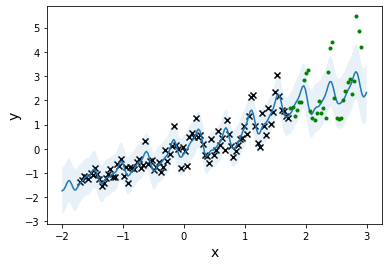

In [51]:
GK = GreedyKernel(algebra, kernels_list)
GK.grow_tree(X_train, y_train, 4)
model = GK.fit_model(X_train, y_train, GK.kernel, n_epochs=500)
plot_model_learned(model, X_test, y_test)

## Bonus Task
Try to approximate rastrigin function

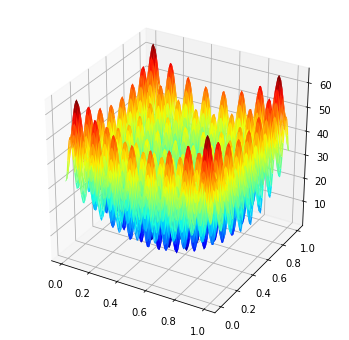

In [52]:
fig = plot_2d_func(rastrigin)

### Training set

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [54]:
torch.manual_seed(0)
X = torch.rand(200, 2, dtype=torch.float64)
y = torch.tensor(rastrigin(X.numpy()), dtype=torch.float64)

#### Hint: you can constrain parameters of the covariance functions, for example
`model.std_periodic.period.constrain_bounded(0, 0.2)`.

In [55]:
######## Your code here ########
constraint = gpytorch.constraints.Interval(0.0, 0.2)

kernel = kernels.ScaleKernel(kernels.RBFKernel() *
                             (kernels.PeriodicKernel(active_dims=[0], period_length_constraint=constraint) *
                              kernels.PeriodicKernel(active_dims=[1], period_length_constraint=constraint)))

model = GPRegressor(X, y, kernel)
model.likelihood.noise = 1e-4
model.double()

### Your code ends here ###

with gpytorch.settings.fast_computations(False, False, False):
    train(model, X, y, n_epochs=4000)

  0%|          | 0/4000 [00:00<?, ?it/s]/home/yeahrmek/miniconda3/envs/bayes_opt/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 4000/4000 [01:44<00:00, 38.27it/s, Loss=4.023, noise=0.0001] 


In [56]:
for name, p in model.named_hyperparameters():
    print(name, f"{p.item():.3f}")

likelihood.noise_covar.raw_noise -inf
mean.constant 41.728
kernel.raw_outputscale 5.507
kernel.base_kernel.kernels.0.raw_lengthscale -0.953
kernel.base_kernel.kernels.1.kernels.0.raw_lengthscale 1.276
kernel.base_kernel.kernels.1.kernels.0.raw_period_length 0.528
kernel.base_kernel.kernels.1.kernels.1.raw_lengthscale 1.339
kernel.base_kernel.kernels.1.kernels.1.raw_period_length 0.504


MSE: 1.2406353732646294


/home/yeahrmek/miniconda3/envs/bayes_opt/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


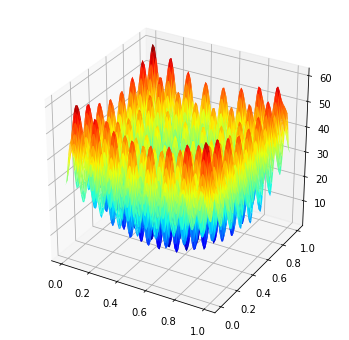

In [57]:
x_test = torch.rand(1000, 2).double()
y_test = rastrigin(x_test.numpy())
y_pr = model.predict(x_test).mean.numpy()

mse = mean_squared_error(y_test.ravel(), y_pr.ravel())
print('MSE: {}'.format(mse))

fig = plot_2d_func(lambda x: model.predict(torch.tensor(x)).mean.numpy())

# Appendix: Gaussian Process Classification

### Classification

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \{+1, -1\} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
p(y = +1 \; | \; x) = \sigma(f(x)) = \pi(x),
$$
where latent function $f(x)$ is a Gaussian Processes.

We need to produce a probabilistic prediction
$$
\pi_* = p(y_* \; | \; X, \mathbf{y}, x_*) = \int \sigma(f_*) p(f_* \; | \; X, \mathbf{y}, x_*) df_*,
$$
$$
p(f_* \; | \; X, \mathbf{y}, x_*) = \int p(f_* \; | \; X, x_*, \mathbf{f}) p(\mathbf{f} \; | \; X, \mathbf{y}) d\mathbf{f},
$$
where $p(\mathbf{f} \; |\; X, \mathbf{y}) = \dfrac{p(\mathbf{y} | X, \mathbf{f}) p(\mathbf{f} | X)}{p(\mathbf{y} | X)}$ is the posterior over the latent variables.

Both integrals are intractable.

Use approximation technique like Laplace approximation, Expectation Propagation or Variational Inference.

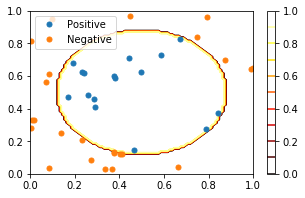

In [58]:
from matplotlib import cm

def cylinder(x):
    y = (1 / 7.0 - (x[:, 0] - 0.5)**2 - (x[:, 1] - 0.5)**2) > 0
    return y

np.random.seed(42)
X = torch.rand(40, 2, dtype=torch.float64)
y = torch.from_numpy(cylinder(X.numpy())).double()

x_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
y_grid = cylinder(np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))).reshape(x_grid[0].shape)

positive_idx = y.numpy() == 1
plt.figure(figsize=(5, 3))
plt.plot(X.numpy()[positive_idx, 0], X.numpy()[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(X.numpy()[~positive_idx, 0], X.numpy()[~positive_idx, 1], '.', markersize=10, label='Negative')
im = plt.contour(x_grid[0], x_grid[1], y_grid, 10, cmap=cm.hot)
plt.colorbar(im)
plt.legend()
plt.show()

In [59]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPClassifier(AbstractVariationalGP):
    def __init__(self, X, y, kernel, likelihood=None):
        variational_distribution = CholeskyVariationalDistribution(X.shape[0])
        variational_strategy = VariationalStrategy(self, X, variational_distribution)
        if likelihood is None:
            likelihood = gpytorch.likelihoods.BernoulliLikelihood()

        super().__init__(variational_strategy)
        self.mean = gpytorch.means.ConstantMean()
        self.kernel = kernel
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return self.likelihood(pred)

In [60]:
# Find optimal model hyperparameters
def train_classifier(model, X, y, n_epochs=100, fix_noise_variance=None, verbose=True):
    model.train()
        
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.VariationalELBO(model.likelihood, model, y.shape[0])

    with tqdm.trange(n_epochs, disable=not verbose) as bar:
        for i in bar:
    
            optimizer.zero_grad()
            
            out = model(X)
            loss = -mll(out, y)
            loss.backward()

            optimizer.step()
            bar.set_postfix(Loss=f"{loss.item():.3f}")

In [61]:
def plot_model_2d(model):

    size = 100
    x_grid = torch.meshgrid(torch.linspace(0, 1, size),
                            torch.linspace(0, 1, size))
    x_grid = torch.cat((x_grid[0].reshape(-1, 1),
                        x_grid[1].reshape(-1, 1)), dim=1)
    y_grid = cylinder(x_grid)
    y_grid = y_grid.reshape(size, -1).numpy()

    with torch.no_grad():
        prediction = model.likelihood(model(x_grid.double()))
        mean = prediction.mean.numpy().reshape(size, -1)
        mean = mean > 0.5
    
    x_grid = x_grid.numpy()
    
    plt.contourf(x_grid[:, 0].reshape(size, -1),
                 x_grid[:, 1]. reshape(size, -1),
                 mean, levels=40)
    
    plt.plot(X.numpy()[positive_idx, 0], X.numpy()[positive_idx, 1], '.', markersize=10, label='Positive')
    plt.plot(X.numpy()[~positive_idx, 0], X.numpy()[~positive_idx, 1], '.', markersize=10, label='Negative')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [00:00<00:00, 99.28it/s, Loss=0.690]


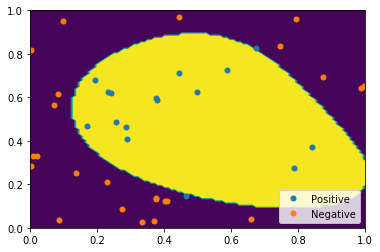

In [62]:
kernel = kernels.ScaleKernel(kernels.RBFKernel(ard_num_dims=2))

model = GPClassifier(X, y, kernel).double()
train_classifier(model, X, y, n_epochs=100)
    
plot_model_2d(model)

Let's change lengthscale to some small value

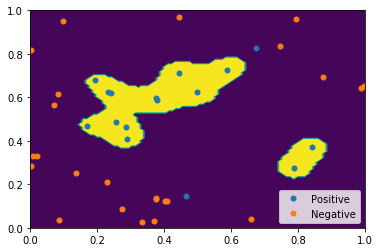

In [63]:
model.kernel.base_kernel.lengthscale = torch.tensor([[0.05, 0.05]]).double()
plot_model_2d(model)